<a href="https://colab.research.google.com/github/rockmonish7/511323106032-cracking-the-market-code/blob/main/511323106032_cracking_the_market_coder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


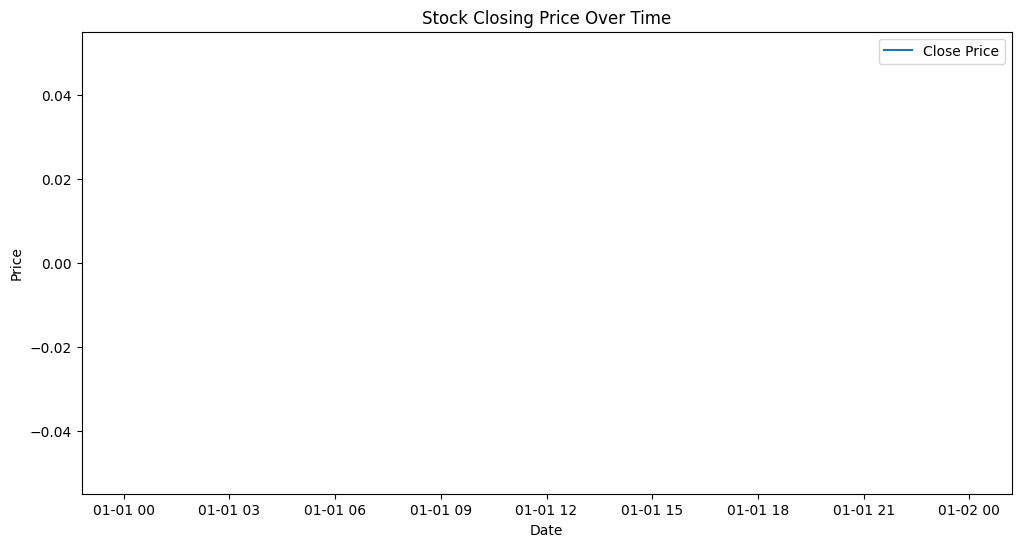

LinAlgError: Schur decomposition solver error.

In [ ]:
# stock_prediction_pipeline.py

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")


# -----------------------------
# 1. Data Collection
# -----------------------------
def get_stock_data(ticker="AAPL", start="2015-01-01", end="2023-12-31"):
    data = yf.download(ticker, start=start, end=end)
    return data[["Close"]]


# -----------------------------
# 2. Data Preprocessing
# -----------------------------
def preprocess_data(data):
    data = data.dropna()
    return data


# -----------------------------
# 3. EDA
# -----------------------------
def plot_eda(data):
    plt.figure(figsize=(12, 6))
    plt.plot(data, label='Close Price')
    plt.title('Stock Closing Price Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


# -----------------------------
# 4. Feature Engineering
# -----------------------------
def create_lag_features(data, lags=5):
    for i in range(1, lags + 1):
        data[f"lag_{i}"] = data["Close"].shift(i)
    return data.dropna()


# -----------------------------
# 5A. ARIMA Model
# -----------------------------
def train_arima(data):
    model = ARIMA(data['Close'], order=(5, 1, 0))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=30)
    return forecast


# -----------------------------
# 5B. LSTM Model
# -----------------------------
def train_lstm(data, time_steps=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[['Close']])

    X, y = [], []
    for i in range(time_steps, len(scaled_data)):
        X.append(scaled_data[i - time_steps:i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=10, batch_size=32, verbose=0)

    predicted = model.predict(X)
    predicted_prices = scaler.inverse_transform(predicted)
    return predicted_prices, scaler.inverse_transform(y.reshape(-1, 1))


# -----------------------------
# 6. Evaluation
# -----------------------------
def evaluate(y_true, y_pred, model_name="Model"):
    mse = mean_squared_error(y_true, y_pred)
    print(f"{model_name} MSE: {mse:.4f}")


# -----------------------------
# 7. Visualization
# -----------------------------
def plot_predictions(y_true, y_pred, title="Model Predictions"):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label="Actual")
    plt.plot(y_pred, label="Predicted")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()


# -----------------------------
# 8. Pipeline Runner
# -----------------------------
def main():
    # Step 1 & 2
    data = get_stock_data()
    data = preprocess_data(data)

    # Step 3
    plot_eda(data)

    # Step 4
    data_lagged = create_lag_features(data.copy())

    # Step 5A: ARIMA
    arima_forecast = train_arima(data)
    print("ARIMA Forecast:\n", arima_forecast)

    # Step 5B: LSTM
    lstm_pred, y_true = train_lstm(data)
    evaluate(y_true, lstm_pred, "LSTM")
    plot_predictions(y_true, lstm_pred, "LSTM Predictions")

    # Optional: Combine predictions for Hybrid Model

if __name__ == "__main__":
    main()

